In [ ]:
from google.colab import drive
import os
import numpy as np
drive.mount('/content/drive',force_remount=True)
os.chdir('/content/drive/My Drive/inria')


Mounted at /content/drive


In [ ]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
import tensorflow as tf

def unet(pretrained_weights = None,input_size = (192,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs=inputs, outputs = conv10)

    model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    #if(pretrained_weights):
    #	model.load_weights(pretrained_weights)

    return model


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

seed = 2 # (IMPORTANT) to transform image and corresponding mask with same augmentation parameter.
image_datagen = ImageDataGenerator(dtype=np.float32,
                                   rescale=1./255,#width_shift_range=0.1,
                 #height_shift_range=0.1,
                 #preprocessing_function = image_preprocessing
                                  ) # custom fuction for each image you can use resnet one too.
mask_datagen = ImageDataGenerator(dtype=np.float32,
                                  rescale=1./255,#width_shift_range=0.1,
                 #height_shift_range=0.1,
                 #preprocessing_function = mask_preprocessing
                                 )  # to make mask as feedable formate (256,256,1)

image_generator =image_datagen.flow_from_directory("./masked",
                                                    class_mode=None,
                                                    seed=seed,
                                                    color_mode="grayscale",
                                                   target_size=(96, 96))

mask_generator = mask_datagen.flow_from_directory("./mask",
                                                   class_mode=None, seed=seed,color_mode="grayscale",target_size=(96, 96))

train_generator = zip(image_generator, mask_generator)

Found 193 images belonging to 1 classes.
Found 193 images belonging to 1 classes.


In [ ]:
from keras.callbacks import Callback 
import keras.callbacks as callbacks

checkpointer = callbacks.ModelCheckpoint(filepath = './weights.hdf5',save_best_only=True)
training_log = callbacks.TensorBoard(log_dir='./log')
earlystopping = callbacks.EarlyStopping(monitor='loss',patience=3,verbose=1,mode='auto',baseline=None,restore_best_weights=True)
history_logger1=tf.keras.callbacks.CSVLogger('./history1', separator=",", append=True)

In [ ]:
model = unet(input_size=(96,96,1))
#model.summary()

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=193,
    epochs=16,
    batch_size=8,
    callbacks=[earlystopping,checkpointer])

Epoch 1/16
193/193 [==============================] - 113s 576ms/step - loss: 1.1073 - accuracy: 0.7809
Epoch 2/16
193/193 [==============================] - 111s 575ms/step - loss: 0.2497 - accuracy: 0.9377
Epoch 3/16
193/193 [==============================] - 110s 572ms/step - loss: 0.2288 - accuracy: 0.9414
Epoch 4/16
193/193 [==============================] - 111s 574ms/step - loss: 0.2135 - accuracy: 0.9440
Epoch 5/16
193/193 [==============================] - 110s 572ms/step - loss: 0.2015 - accuracy: 0.9441
Epoch 6/16
193/193 [==============================] - 111s 574ms/step - loss: 0.1936 - accuracy: 0.9422
Epoch 7/16
193/193 [==============================] - 110s 571ms/step - loss: 0.1856 - accuracy: 0.9433
Epoch 8/16
193/193 [==============================] - 111s 574ms/step - loss: 0.1791 - accuracy: 0.9423
Epoch 9/16
193/193 [==============================] - 110s 574ms/step - loss: 0.1723 - accuracy: 0.9435
Epoch 10/16
193/193 [==============================] - 110s 570m

In [ ]:
from matplotlib import image
from matplotlib import pyplot as plt 
import numpy as np
from skimage import color
from skimage import io
from skimage.util import compare_images
from scipy.ndimage.morphology import binary_fill_holes
import os

In [ ]:
a = color.rgb2gray(image.imread('./masked/img/0_surgical.png'))
b = color.rgb2gray(image.imread('./mask/img/0.png'))

print(np.unique(b))       

[0.         0.99999994]


In [ ]:
x = mask_generator.next()
np.unique(x)

array([  0., 255.], dtype=float32)

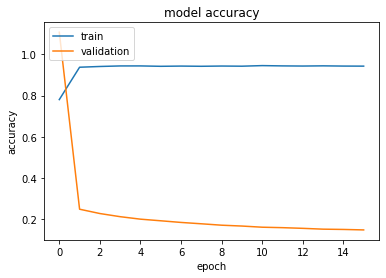

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

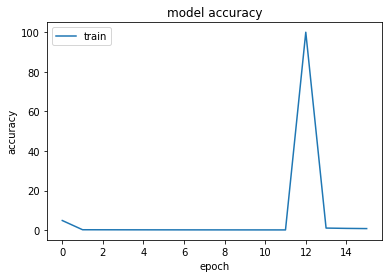

In [ ]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(image_generator.next())
pred.shape

(32, 96, 96, 1)

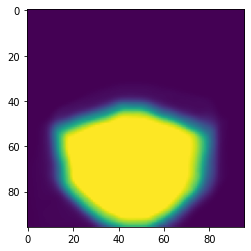

In [ ]:
plt.imshow(pred[3,:,:,0])

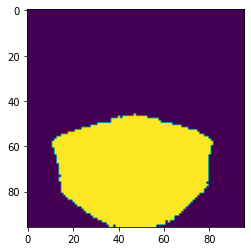

In [ ]:
plt.imshow(mask_generator.next()[3,:,:,0])

In [ ]:
git